Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

## Dependencies

In [1]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

## Plotting and metrics imports
from metrics import get_plotting_color, plot_examples, plot_class_distribution, plot_results, plot_scores_per_class, plot_weights

## Other functions imports
from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity, calculate_grad_snr

## MLP imports
from MLP import MLP, NodePerturbMLP, KolenPollackMLP


## Data

In [3]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [4]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Hyperparams

In [5]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345
rng = np.random.default_rng(seed=seed)
# select 1000 random images to test the accuracy on
indices = rng.choice(range(test_images.shape[1]), size=(1000,), replace=False)


## Backprop

In [20]:
losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
test_loss_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], test_loss_backprop[:], _) = \
    netbackprop.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  0.44 .
...completed  2.0  epochs of training. Current loss:  0.32 .
...completed  3.0  epochs of training. Current loss:  0.27 .
...completed  4.0  epochs of training. Current loss:  0.24 .
...completed  5.0  epochs of training. Current loss:  0.22 .
...completed  6.0  epochs of training. Current loss:  0.2 .
...completed  7.0  epochs of training. Current loss:  0.19 .
...completed  8.0  epochs of training. Current loss:  0.19 .
...completed  9.0  epochs of training. Current loss:  0.18 .
...completed  10.0  epochs of training. Current loss:  0.18 .
...completed  11.0  epochs of training. Current loss:  0.17 .
...completed  12.0  epochs of training. Current loss:  0.17 .
...completed  13.0  epochs of training. Current loss:  0.17 .
...completed  14.0  epochs of training. Current loss:  0.16 .
...completed  15.0  epochs of training. Current loss:  0.16 .
...completed  16.0  epochs of training. Current loss:  0.16

## Online Learning

In [7]:
# create a network and train it using backprop
netonline = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_online, accuracy_online, test_loss_online, _) = \
    netonline.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=numupdates*batchsize, conv_loss = 1e-2, algorithm='backprop', noise=noise, \
                      report=report, report_rate=100)

Training starting...
...completed  1000  iterations of training data (single images). Current loss:  0.93 .
...completed  2000  iterations of training data (single images). Current loss:  0.61 .
...completed  3000  iterations of training data (single images). Current loss:  0.36 .
...completed  4000  iterations of training data (single images). Current loss:  0.13 .
...completed  5000  iterations of training data (single images). Current loss:  0.13 .
...completed  6000  iterations of training data (single images). Current loss:  0.1 .
...completed  7000  iterations of training data (single images). Current loss:  0.99 .
...completed  8000  iterations of training data (single images). Current loss:  0.15 .
...completed  9000  iterations of training data (single images). Current loss:  0.25 .
...completed  10000  iterations of training data (single images). Current loss:  0.12 .
...completed  10324  iterations of training data (single images). Current loss:  0.01 .
Training complete.


## Non-stationary Data

In [8]:
# create a network and train it using backprop
netnonstat = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_nonstat, accuracy_nonstat, test_loss_nonstat, _) = \
    netnonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=1)

Training starting...
...completed  1  epochs of training. Current loss:  0.22 .
...completed  2  epochs of training. Current loss:  0.15 .
...completed  3  epochs of training. Current loss:  0.12 .
...completed  4  epochs of training. Current loss:  0.1 .
...completed  5  epochs of training. Current loss:  0.09 .
...completed  6  epochs of training. Current loss:  0.09 .
...completed  7  epochs of training. Current loss:  0.08 .
...completed  8  epochs of training. Current loss:  0.08 .
...completed  9  epochs of training. Current loss:  0.07 .
...completed  10  epochs of training. Current loss:  0.07 .
...completed  11  epochs of training. Current loss:  0.07 .
...completed  12  epochs of training. Current loss:  0.07 .
...completed  13  epochs of training. Current loss:  0.06 .
...completed  14  epochs of training. Current loss:  0.56 .
...completed  15  epochs of training. Current loss:  0.39 .
...completed  16  epochs of training. Current loss:  0.33 .
...completed  17  epochs of t

## Noisy Input Data

In [9]:
# create a network and train it using backprop
netnoisy = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses__noisy_input, accuracy_noisy_input, test_loss_noisy_input, _) = \
    netnoisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  0.48 .
...completed  2.0  epochs of training. Current loss:  0.37 .
...completed  3.0  epochs of training. Current loss:  0.32 .
...completed  4.0  epochs of training. Current loss:  0.29 .
...completed  5.0  epochs of training. Current loss:  0.27 .
...completed  6.0  epochs of training. Current loss:  0.25 .
...completed  7.0  epochs of training. Current loss:  0.24 .
...completed  8.0  epochs of training. Current loss:  0.23 .
...completed  9.0  epochs of training. Current loss:  0.22 .
...completed  10.0  epochs of training. Current loss:  0.22 .
...completed  11.0  epochs of training. Current loss:  0.21 .
...completed  12.0  epochs of training. Current loss:  0.21 .
...completed  13.0  epochs of training. Current loss:  0.2 .
...completed  14.0  epochs of training. Current loss:  0.2 .
...completed  15.0  epochs of training. Current loss:  0.19 .
...completed  16.0  epochs of training. Current loss:  0.19 

## Node Perturbation

In [1]:
# @title Train and observe the performance of NodePerturbMLP

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
with contextlib.redirect_stdout(io.StringIO()):
    netnodeperturb = NodePerturbMLP(rng_np, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
    (losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
        netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                             report=report, report_rate=rep_rate)


NameError: name 'np' is not defined

## Kolen-Pollack

In [ ]:
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
test_loss_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], test_loss_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng = np.random.default_rng(seed=seed)

Training starting...
...completed  1.0  epochs of training. Current loss:  0.57 .
...completed  2.0  epochs of training. Current loss:  0.39 .
...completed  3.0  epochs of training. Current loss:  0.31 .
...completed  4.0  epochs of training. Current loss:  0.27 .
...completed  5.0  epochs of training. Current loss:  0.25 .
...completed  6.0  epochs of training. Current loss:  0.23 .
...completed  7.0  epochs of training. Current loss:  0.22 .
...completed  8.0  epochs of training. Current loss:  0.21 .
...completed  9.0  epochs of training. Current loss:  0.2 .
...completed  10.0  epochs of training. Current loss:  0.19 .
...completed  11.0  epochs of training. Current loss:  0.19 .
...completed  12.0  epochs of training. Current loss:  0.18 .
...completed  13.0  epochs of training. Current loss:  0.18 .
...completed  14.0  epochs of training. Current loss:  0.18 .
...completed  15.0  epochs of training. Current loss:  0.18 .
...completed  16.0  epochs of training. Current loss:  0.17

## Results

In [11]:
# Calculate the moving average
from scipy.ndimage import uniform_filter1d
window_size = 100
losses_online_mean = uniform_filter1d(losses_online, size=window_size)

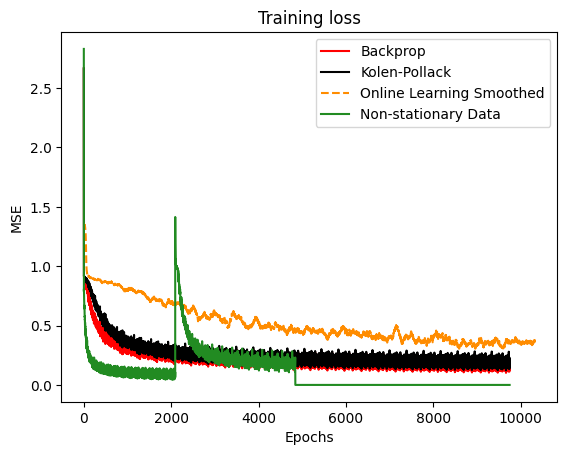

In [13]:
#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.plot(losses_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.plot(losses_online, label="Online Learning", color='gold')
plt.plot(losses_online_mean, label="Online Learning Smoothed", color='darkorange', linestyle='dashed')
plt.plot(losses_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(losses_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

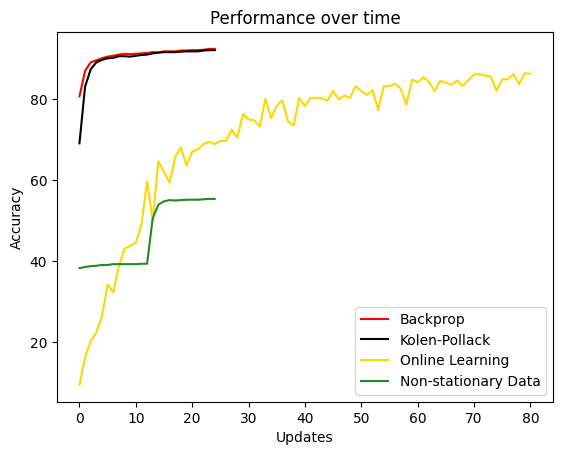

In [14]:
accuracy_online = accuracy_online[::batchsize]
#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(accuracy_backprop, label="Backprop", color='r')
plt.plot(accuracy_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(accuracy_node_perturb, label="Node Perturbation", color='c')
plt.plot(accuracy_online, label="Online Learning", color='gold')
plt.plot(accuracy_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(accuracy_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Updates")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")
plt.show()

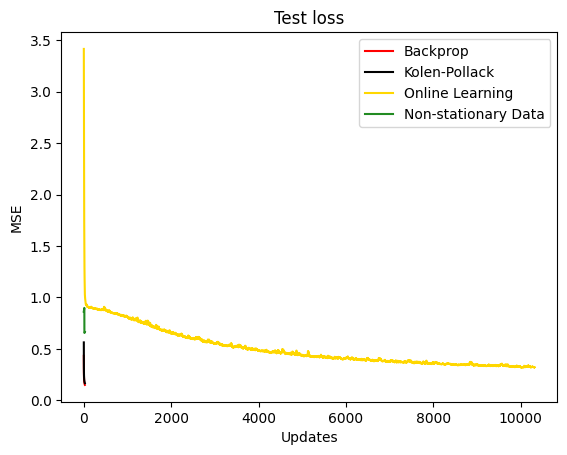

In [15]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(test_loss_backprop, label="Backprop", color='r')
plt.plot(test_loss_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(test_loss_node_perturb, label="Node Perturbation", color='c')
plt.plot(test_loss_online, label="Online Learning", color='gold')
plt.plot(test_loss_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(test_loss_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")
plt.show()

## Forward-forward Method

### Initialization

In [6]:
import importlib
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig
import warnings
warnings.filterwarnings("ignore")

import net_ff_model
import importlib

# Reload the modules
importlib.reload(net_ff_model)




<module 'net_ff_model' from 'd:\\MyFolders\\project\\2024summer\\NeuroAI\\NMA-Microlearning-Project\\net_ff_model.py'>

### Training (Normal Situation)

In [9]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ff = net_ff_model.net_FF_model(rng)
losses_ff, accuracy_ff, testing_accuracies = net_ff.train_over(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  59.158982765980255, 

            Current training cross_entropy loss:  1.7674111109513504, 

            Current testing cross_entropy loss:  1.218001365661621, 
   
            Current testing accuracy:  0.795 
         
            
...completed  1  epochs of

### Training (Online)

In [36]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ff_online = net_ff_model.net_FF_model(rng)
losses_ff_online, accuracy_ff_online, testing_accuracies_online = net_ff_online.train_online(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    max_it=25000, conv_loss=1e-23, 
    report_rate=100, lr=0.001,
    model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  1  iterations of training. 

                Current testing accuracy:  nan 

                Current testing loss:  nan 
 
...completed  1001  iterations of training. 

                Current testing accuracy:  0.22085858585858587 

                Current testing loss:  2.2016964608972724 
 
...completed  2001  itera

### Training (Non-stationary)

In [7]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ff_nonstat = net_ff_model.net_FF_model(rng)
losses_ff_nonstat, accuracy_ff_nonstat, testing_accuracies_nonstat = net_ff_nonstat.train_nonstationary(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)


seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  54.471088670055316, 

            Current training cross_entropy loss:  1.099217044640772, 

            Current testing cross_entropy loss:  3.155848741531372, 
   
            Current testing accuracy:  0.371 
         
            


KeyboardInterrupt: 

### Training (Noisy Input)

In [8]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ff_noisydata = net_ff_model.net_FF_model(rng)
losses_ff_noisydata, accuracy_ff_noisydata, testing_accuracies_noisydata = net_ff_noisydata.train_noisydata(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  59.019286527389134, 

            Current training cross_entropy loss:  1.762605063426189, 

            Current testing cross_entropy loss:  1.2111436128616333, 
   
            Current testing accuracy:  0.798 
         
            
...completed  1  epochs of